In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import h5py
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

/Users/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path = "/Users/scott/Dropbox/data/krista perks/20180824_000_SPK.mat"

In [3]:
f = h5py.File(data_path)

In [4]:
for k in f['CmdTrig'].keys():
    print(k)

comment
length
resolution
times
title


In [5]:
dt = f['CmdTrig']['resolution'].value[0, 0]   # resolution in seconds
ts = f['CmdTrig']['times'].value[0]           # event times in seconds
t_start = 0
t_stop = ts.max() + 1

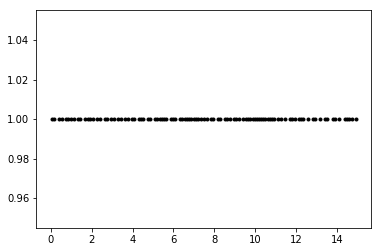

In [6]:
plt.plot(ts[:100], np.ones(100), 'k.')

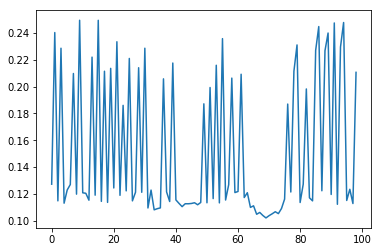

In [7]:
plt.plot(np.diff(ts[:100]))

In [8]:
bin_width = 0.050 
bins = np.arange(t_start, t_stop, bin_width)
bin_count, _ = np.histogram(ts, bins) 
emp_rate = bin_count / bin_width

In [9]:
# smooth with a gaussian filter
smooth_rate = gaussian_filter1d(emp_rate, 3)

(1200, 1260)

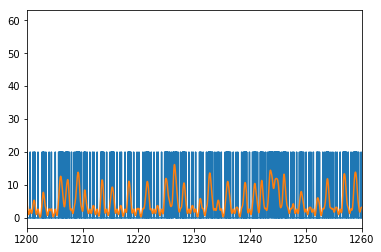

In [10]:
plt.plot(bins[:-1], emp_rate)
plt.plot(bins[:-1], smooth_rate)
plt.xlim(20*60, 21*60)

(1500, 1680)

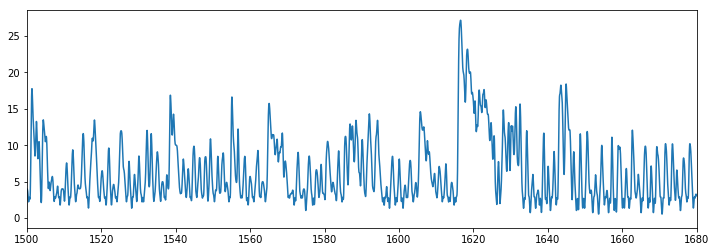

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(bins[:-1], smooth_rate)
plt.xlim(25*60, 28*60)

(1500, 1680)

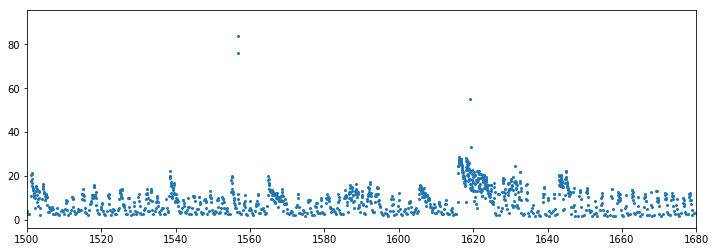

In [12]:
plt.figure(figsize=(12, 4))
plt.scatter(ts[:-1], 1/ np.diff(ts), s=4)
plt.xlim(25*60, 28*60)

# Fit a Hawkes process!

In [13]:
from pyhawkes.models import ContinuousTimeNetworkHawkesModel

In [14]:
model = ContinuousTimeNetworkHawkesModel(K=1, dt_max=.300, network_hypers=dict(p=1.0))

In [15]:
model.add_data(ts, np.zeros(len(ts), dtype=int), t_stop)

In [16]:
for _ in tqdm.tqdm(range(100)): 
    model.resample_model()

100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


In [17]:
model_rate = model.compute_rate(ts, np.zeros(len(ts), dtype=int), t_stop, dt=bin_width)

In [18]:
model_rate, model_bins = model_rate

In [19]:
impulses, t_impulses = model.compute_impulses(dt=0.01)

/Users/scott/Projects/pyhawkes/pyhawkes/internals/impulses.py:372: RuntimeWarning: divide by zero encountered in true_divide
  return 1./Z * np.exp(-tau/2. * (logit(dt/dt_max) - mu)**2)
/Users/scott/Projects/pyhawkes/pyhawkes/utils/utils.py:68: RuntimeWarning: divide by zero encountered in log
  return np.log(x/lam_max)-np.log(1-(x/lam_max))
/Users/scott/Projects/pyhawkes/pyhawkes/internals/impulses.py:372: RuntimeWarning: invalid value encountered in multiply
  return 1./Z * np.exp(-tau/2. * (logit(dt/dt_max) - mu)**2)


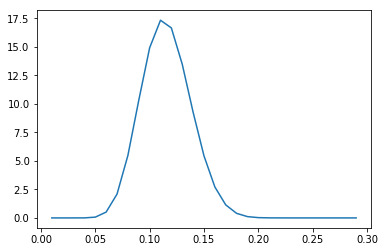

In [20]:
plt.plot(t_impulses, impulses[:, 0, 0])

In [22]:
model.W_effective

array([[0.45345728]])

(1200, 1215.0)

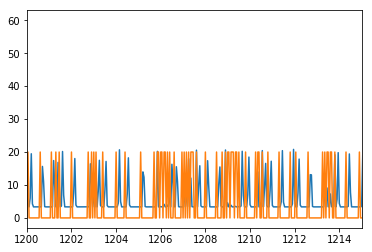

In [26]:
plt.plot(model_bins, model_rate)
# plt.plot(bins[:-1], smooth_rate)
plt.plot(bins[:-1], emp_rate)
plt.xlim(20*60, 20.25*60)

In [28]:
ts_sim, _ = model.generate(keep=False, T=3*60)

(0, 100)

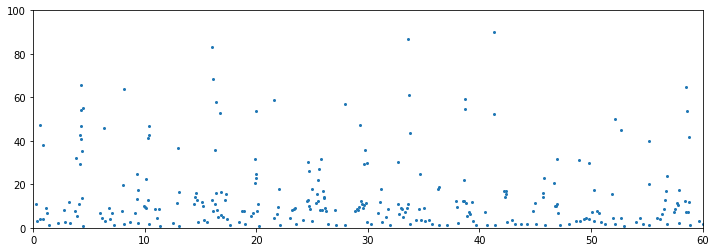

In [33]:
plt.figure(figsize=(12, 4))
plt.scatter(ts_sim[:-1], 1/ np.diff(ts_sim), s=4)
plt.xlim(0*60, 1*60)
plt.ylim(0, 100)

(0, 100)

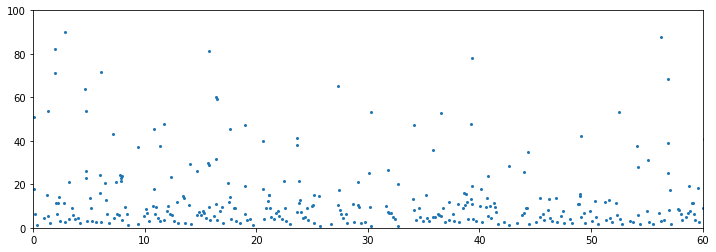

In [36]:
ts_rand = sorted(np.random.rand(len(ts_sim)) * (3 * 60))

plt.figure(figsize=(12, 4))
plt.scatter(ts_rand[:-1], 1/ np.diff(ts_rand), s=4)
plt.xlim(0*60, 1*60)
plt.ylim(0, 100)